In [1]:
import os
import datetime
import pytz
import re
from tqdm import tqdm
import json
import base64
import fiftyone as fo
import pkg_resources


/tmp/ipykernel_15819/2552815744.py:9: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [2]:
# Set metadata for import with fiftyone
def set_v51_metadata(output_base_dir):

    # Define sample fields
    sample_fields = [
        {
            "name": "filepath",
            "ftype": "fiftyone.core.fields.StringField",
            "embedded_doc_type": None,
            "subfield": None,
            "fields": [],
            "db_field": "filepath",
            "description": None,
            "info": None,
            "read_only": True,
            "created_at": {
                "$date": "2024-11-14T15:24:21.719Z"
            }
        },
        {
            "name": "sensor",
            "ftype": "fiftyone.core.fields.StringField",
            "embedded_doc_type": None,
            "subfield": None,
            "fields": [],
            "db_field": "sensor",
            "description": None,
            "info": None,
            "read_only": True,
            "created_at": {
                "$date": "2024-11-14T15:24:21.719Z"
            }
        },
        {
            "name": "timestamp",
            "ftype": "fiftyone.core.fields.DateTimeField",
            "embedded_doc_type": None,
            "subfield": None,
            "fields": [],
            "db_field": "timestamp",
            "description": None,
            "info": None,
            "read_only": True,
            "created_at": {
                "$date": "2024-11-14T15:24:21.719Z"
            }
        }
    ]
    
    # Get version of current V51 package
    package_name = 'fiftyone'
    version = pkg_resources.get_distribution(package_name).version
    version_str = str(version)

    v51_metadata = {}
    v51_metadata["name"] = "Data Engine Rolling Dataset"
    v51_metadata["version"] = version_str
    v51_metadata["sample_fields"] = sample_fields

    file_path = os.path.join(output_base_dir, "metadata.json")
    with open(file_path, 'w') as json_file:
        json.dump(v51_metadata, json_file)

In [3]:
def create_v51_dataset(output_base_dir, name="Data Engine Rolling Dataset", delete_old_dataset=True, NUM_WORKERS=32):

    # Create the dataset
    dataset = fo.Dataset(name = name, overwrite=delete_old_dataset)

    dataset.add_dir(
        dataset_dir=output_base_dir,
        dataset_type=fo.types.FiftyOneDataset,
        progress=True,
    )

    dataset.compute_metadata(num_workers=NUM_WORKERS, progress=True)

    return dataset

In [4]:
time_differences = []

def save_base64_images(file_path, output_base_dir, v51_samples_array):
    
    data_target = os.path.join(output_base_dir, "data")
    os.makedirs(data_target, exist_ok=True)
    
    with open(file_path, 'r') as file:
        for line in tqdm(file, desc=f"Processing {file_path}"):
            try:
                data = json.loads(line)
                v51_sample = {}
                if "time" in data and "data" in data:
                    # Get data
                    timestamp = data.get("time")
                    image_base64 = data.get("data")
                    sensor_name = data.get("device_name")

                    # Get timestamp
                    time_obj = datetime.datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S.%f')
                    formatted_time = time_obj.strftime('%Y-%m-%dT%H:%M:%S.%f')[:-3] + 'Z'
                    
                elif "image" in data and "sensor_name" in data and "event_timestamp" in data:
                    # Get data
                    image_base64 = data.get("image")
                    sensor_name = data.get("sensor_name")
                    timestamp = data.get("event_timestamp")
                    
                    # Get timestamps in UTC and Michigan time
                    utc_time = datetime.datetime.fromtimestamp(timestamp, tz=datetime.timezone.utc)
                    michigan_tz = pytz.timezone('America/Detroit')
                    michigan_time = utc_time.astimezone(michigan_tz)
                    formatted_time = michigan_time.strftime('%Y-%m-%dT%H:%M:%S.%f')[:-3] + 'Z'
                    # TODO Make sure that the conversion to Michigan time is correct
                else:
                    unpacking_successful = False
                    print(f"Format cannot be processed: {data}")
                    continue
                
                if image_base64 and formatted_time:
                    # Decode the base64 image data
                    image_data = base64.b64decode(image_base64)

                    # File paths
                    image_filename = f"{sensor_name}_{formatted_time}.jpg"
                    output_path = os.path.join(data_target, image_filename)

                    # Ensure correct timestamp format
                    milliseconds = formatted_time.split('.')[1][:3].ljust(3, '0')
                    formatted_time = formatted_time.split('.')[0] + '.' + milliseconds + 'Z'
                    iso8601_regex = re.compile(r'^\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}(\.\d{3})?Z$')
                    iso8601_conform = bool(iso8601_regex.match(formatted_time))
                    if not iso8601_conform:
                        print(f"Timestamp does not conform to ISO8601: {formatted_time}")

                    # Prepare import with V51
                    v51_sample["filepath"] = output_path
                    v51_sample["sensor"] = sensor_name
                    v51_sample["timestamp"] = {"$date": formatted_time}
                    v51_samples_array.append(v51_sample) 

                    # Save the decoded image data as a JPEG
                    with open(output_path, 'wb') as image_file:
                        image_file.write(image_data)
                else:
                    unpacking_successful = False
                    print(f"There was an issue during file processing of {file}")
                    continue
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")
    



def calculate_time_differences(v51_samples_array):
    timestamps = [sample["timestamp"]["$date"] for sample in v51_samples_array]
    timestamps.sort()
    previous_timestamp = None
    timestamp_format = '%Y-%m-%dT%H:%M:%S.%fZ'
    for timestamp in timestamps:
        if previous_timestamp is not None:
            dt_previous_timestamp = datetime.datetime.strptime(previous_timestamp, timestamp_format)
            dt_timestamp = datetime.datetime.strptime(timestamp, timestamp_format)
            time_difference = dt_timestamp - dt_previous_timestamp
            time_differences.append(time_difference.total_seconds())
        previous_timestamp = timestamp


data_path = "/media/dbogdoll/Datasets/data_engine_rolling_processed/1/"
files = os.listdir(data_path)
output_path = os.path.join(data_path, "decoded_sampled")


v51_samples_array = []
for file in tqdm(files, desc="Processing files"):
    if "sip" in file:
        file_path = os.path.join(data_path, file)
        save_base64_images(file_path, output_path, v51_samples_array)

# Store V51 metadata files
v51_samples = {"samples": v51_samples_array}
file_path = os.path.join(output_path, "samples.json")
with open(file_path, 'w') as json_file:
    json.dump(v51_samples, json_file)

set_v51_metadata(output_path)

calculate_time_differences(v51_samples_array)

print(f"Processed {len(v51_samples_array)} images")

create_v51_dataset(output_base_dir=output_path, name="AWS Test Sampled (38)")

Processing /media/dbogdoll/Datasets/data_engine_rolling_processed/1/sip-data-stream2-delivery-stream-2-2024-04-12-16-08-52-8bcf63c8-e46b-3fc9-8855-50eaf824bd39_sampled_1Hz: 325it [00:00, 3043.52it/s]
Processing /media/dbogdoll/Datasets/data_engine_rolling_processed/1/sip-data-stream2-delivery-stream-2-2024-04-12-17-23-13-c6b502c3-b8ef-3073-8851-96ba890eecb0_sampled_1Hz: 261it [00:00, 2572.66it/s]
Processing /media/dbogdoll/Datasets/data_engine_rolling_processed/1/sip-delivery-stream-1-2023-08-30-20-10-16-c43bb59e-7545-30d3-b52e-ef1b76fcc340_sampled_1Hz: 268it [00:00, 2896.87it/s]
Processing /media/dbogdoll/Datasets/data_engine_rolling_processed/1/sip-delivery-stream-1-2023-03-13-18-56-11-1d6c8acc-5073-33f9-ab61-d0d12715541f_sampled_1Hz: 32it [00:00, 436.88it/s]
Processing /media/dbogdoll/Datasets/data_engine_rolling_processed/1/sip-delivery-stream-1-2023-03-13-19-04-50-95d2c432-ded2-31e9-a82d-b7a0a6833f08_sampled_1Hz: 22it [00:00, 447.47it/s]
Processing /media/dbogdoll/Datasets/data_en

Processed 5589 images
Importing samples...
 100% |███████████████| 5589/5589 [34.6ms elapsed, 0s remaining, 161.7K samples/s]  
Computing metadata...
 100% |███████████████| 5589/5589 [261.3ms elapsed, 0s remaining, 21.4K samples/s]     


Name:        AWS Test Sampled (38)
Media type:  None
Num samples: 5589
Persistent:  False
Tags:        []
Sample fields:
    id:               fiftyone.core.fields.ObjectIdField
    filepath:         fiftyone.core.fields.StringField
    tags:             fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    created_at:       fiftyone.core.fields.DateTimeField
    last_modified_at: fiftyone.core.fields.DateTimeField
    sensor:           fiftyone.core.fields.StringField
    timestamp:        fiftyone.core.fields.DateTimeField

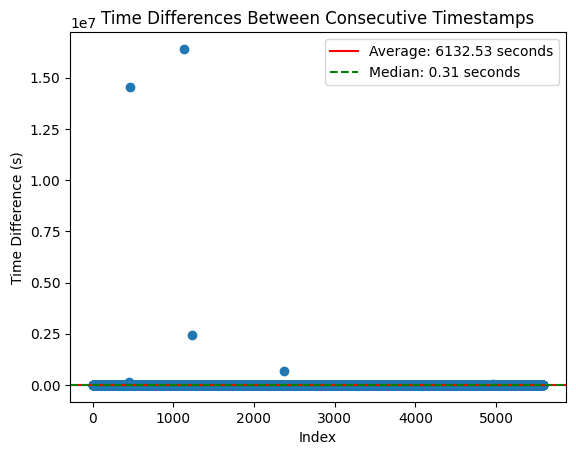

In [5]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(time_differences))
plt.scatter(x, time_differences)

# Calculate average and median
average_time_diff = np.mean(time_differences)
median_time_diff = np.median(time_differences)

plt.axhline(y=average_time_diff, color='r', linestyle='-', label=f'Average: {average_time_diff:.2f} seconds')
plt.axhline(y=median_time_diff, color='g', linestyle='--', label=f'Median: {median_time_diff:.2f} seconds')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Time Difference (s)')
plt.title('Time Differences Between Consecutive Timestamps')
plt.legend()

# Show the plot
plt.show()